In [1]:
import numpy as np
import pandas as pd
import quandl
import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import API key from file
import API_config

In [3]:
quandl.ApiConfig.api_key = API_config.API_KEY

In [4]:
# Set start and end date for stock prices
start_date = datetime.date(2009, 3,8)
end_date = datetime.date.today()
# Load data from Quandl
data = quandl.get('FSE/SAP_X', start_date=start_date, end_date=end_date)
# Save data to CSV file
data.to_csv('data/sap_stock.csv')

In [5]:
# Create DataFrame with only closing price and date
df = pd.DataFrame(data, columns=['Close'])
# Reset index column so that date is proper column
df = df.reset_index()

In [6]:
df.head()

,Date,Close
0,2009-03-09,25.59
1,2009-03-10,26.87
2,2009-03-11,26.64
3,2009-03-12,26.18
4,2009-03-13,25.73


In [7]:
# Check data types in columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 2 columns):
Date     2550 non-null datetime64[ns]
Close    2550 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.9 KB


In [8]:
# Check for missing values in relevant columns 
print(df['Close'].isna().sum())
print(df['Date'].isna().sum())

0
0


In [9]:
# Split data into train and test set: 80% / 20%
train, test = train_test_split(df, test_size=0.20)

In [12]:
# Reshape index column to 2D array for .fit() method
X_train = np.array(train.index).reshape(-1, 1)
y_train = train['Close']

In [20]:
# Create LinearRegression Object
model = LinearRegression()
# Fit linear model using the train data set
model.fit(X_train, y_train)

# The coefficient
print('Coefficient: ', model.coef_)
# The Intercept
print('Intercept: ', model.intercept_)

Coefficient:  [0.02762424]
Intercept:  25.723432313963862


In [16]:
slope = np.asscalar(np.squeeze(model.coef_))
intercept = model.intercept_
print('slope: ', slope, 'intercept: ', intercept)

slope:  0.02762424028961455 intercept:  25.723432313963862


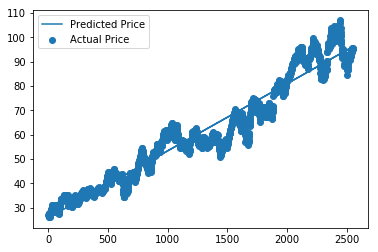

In [37]:
# Train set graph
plt.scatter(X_train, y_train, label='Actual Price')
plt.plot(X_train, model.predict(X_train), label='Predicted Price')
plt.legend()
plt.show()

In [39]:
X_test = np.array(test.index).reshape(-1, 1)
y_test = test['Close']

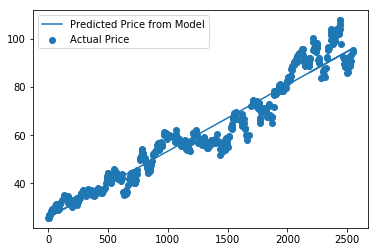

In [45]:
# Train set graph
plt.scatter(X_test, y_test, label='Actual Price')
#plt.plot(X_test, model.predict(X_test), label='Predicted Price')
plt.plot(X_test, slope * X_test + intercept, linestyle='solid', label='Predicted Price from Model')
plt.legend()
plt.show()